# DATA698 - City University of New York
# Final Research Paper
## Deep learning vs Machine Learning
## By: Sang Yoon (Andy) Hwang
## Date: 2019-12-09

# Dependencies

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import seaborn as sns
import numpy as np
import math
import functools
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

# Import csvs
services = pd.read_csv('services.csv')
status = pd.read_csv('status.csv')
population = pd.read_csv('population.csv')
location = pd.read_csv('location.csv')
demographics = pd.read_csv('demographics.csv')

In [4]:
services.head()

,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,...,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,8779-QRDMV,1,Q3,No,0,1,None,No,0.00,No,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,Yes,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,1,Q3,No,0,18,Offer D,Yes,11.33,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,1,Q3,Yes,1,25,Offer C,Yes,19.76,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36


In [5]:
status.head()

,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,1,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


In [6]:
population.head()

,ID,Zip Code,Population
0,1,90001,"54,492"
1,2,90002,"44,586"
2,3,90003,"58,198"
3,4,90004,"67,852"
4,5,90005,"43,019"


In [7]:
location.head()

,Customer ID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude
0,8779-QRDMV,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.023810,-118.156582
1,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237
2,1658-BYGOY,1,United States,California,Los Angeles,90065,"34.108833, -118.229715",34.108833,-118.229715
3,4598-XLKNJ,1,United States,California,Inglewood,90303,"33.936291, -118.332639",33.936291,-118.332639
4,4846-WHAFZ,1,United States,California,Whittier,90602,"33.972119, -118.020188",33.972119,-118.020188


In [8]:
demographics.head()

,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1


# data pre-processing

## data merging

Since we have 5 dfs, I will have to merge 5 dfs into one. We will call this dataframe as df.
First of all, I will merge 4 dfs that have CustomerID. Secondly, I will merge again on Zip Code. 

'City' is an interesting variable - it has more than 100 categories. Is it really worth it to keep this variable? My answer is not really as frequency distribution tells me that sample size for each category is too small. Except for LA, San Diego, San Jose, Sacramento and SF, all of them have less than 65 samples (and quite often less than 5) when we have 7043 samples in total.

Thus, I will drop this variable. I will also drop 'Population', 'Churn Label', 'Customer Status', 'Customer ID', 'Count_x', 'Quarter_x', 'Count_y', 'Quarter_y', 'Country', 'State', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude' and 'ID' variables as they are either redundant or not meaningful.

In [9]:
# Merge by CustomerID
pd.set_option('display.max_columns', 1000)
dfs = [services, status, location, demographics]
df = functools.reduce(lambda left,right: pd.merge(left,right, on = 'Customer ID', how = 'inner'), dfs)

# Merge by Zip code
df = df.merge(population, on ='Zip Code', how = 'inner')

In [10]:
# City variable - frequency distribution
df_city = df.groupby('City')['City'].count()
print( df_city.sort_values(ascending = False).head(20) )

# Drop unnecessary columns
df.drop(['City', 'Population', 'Churn Label', 'Customer Status', 'Customer ID', 'Count_x', 'Quarter_x', 'Count_y', 'Quarter_y', 'Country', 'State', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'ID'], axis = 1, inplace = True)
df.head()

City
Los Angeles      293
San Diego        285
San Jose         112
Sacramento       108
San Francisco    104
Fresno            61
Long Beach        60
Oakland           52
Escondido         51
Stockton          44
Fallbrook         43
Glendale          40
Bakersfield       39
Temecula          38
Riverside         32
Berkeley          32
Pasadena          30
Whittier          30
Modesto           28
Santa Barbara     28
Name: City, dtype: int64


,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,No,0,1,None,No,0.00,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.0,20,0.00,59.65,3,1,91,5433,Competitor,Competitor offered more data,Male,78,No,Yes,No,No,0
1,Yes,5,72,None,Yes,42.55,Yes,Yes,DSL,18,Yes,Yes,Yes,Yes,No,No,No,Yes,Two Year,No,Credit Card,72.10,5016.65,0.0,0,3063.60,8080.25,3,0,42,4658,NaN,NaN,Male,39,No,No,Yes,No,0
2,No,0,1,None,Yes,7.11,No,Yes,Fiber Optic,26,No,No,Yes,No,No,No,No,Yes,Month-to-Month,No,Bank Withdrawal,75.55,75.55,0.0,0,7.11,82.66,5,0,34,3503,NaN,NaN,Female,32,No,No,No,No,0
3,Yes,4,66,None,No,0.00,No,Yes,Cable,25,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,56.75,3708.40,0.0,0,0.00,3708.40,3,0,46,5748,NaN,NaN,Male,35,No,No,Yes,Yes,3
4,No,0,7,Offer E,Yes,36.49,No,Yes,Fiber Optic,42,No,Yes,No,No,Yes,Yes,Yes,Yes,One Year,Yes,Credit Card,94.05,633.45,0.0,0,255.43,888.88,3,0,38,5545,NaN,NaN,Female,20,Yes,No,No,No,0


## Summary statistics

The data set contains 7043 observations and 45 variables including the binary response variable, Churn Value (0/1).
Of these columns, 16 are numeric and 29 are objects (categorical or simply text). For some reason, Population is being treated as object but it needs to be converted into numeric for better modeling purpose.

In the following tables, we see the summary statistics for all of the variables in the dataset. They have been broken up into 3 tables for ease of reading. Note that Total Refunds, Total Extra Data Charges and Total number of dependents are fairly positively skewed which may need to be addressed through data transformation or feature selection before developing a model; other predictors show skew and kurtosis, but to a lesser degree. For our case, however, since we are going to focus on non-parametric models only such as Artificial Neural Network, Random Forest, non-linear SVM and XGBoost, normality assumption is not needed.

Missing percentage table shows Churn Category and Churn Reason are missing around 73% of values. This is not a problem since they are meant to be missing as non-churn observations always miss those values. Histogram and Boxplot shows there are outliers in the data. We will design models that are robust to outliers.

In [11]:
print("Data information")
df.info()

Data information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 40 columns):
Referred a Friend                    7043 non-null object
Number of Referrals                  7043 non-null int64
Tenure in Months                     7043 non-null int64
Offer                                7043 non-null object
Phone Service                        7043 non-null object
Avg Monthly Long Distance Charges    7043 non-null float64
Multiple Lines                       7043 non-null object
Internet Service                     7043 non-null object
Internet Type                        7043 non-null object
Avg Monthly GB Download              7043 non-null int64
Online Security                      7043 non-null object
Online Backup                        7043 non-null object
Device Protection Plan               7043 non-null object
Premium Tech Support                 7043 non-null object
Streaming TV                         7043 non-null object
Streamin

In [12]:
print("Summary statistics:")
df.describe()

Summary statistics:


,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Churn Value,Churn Score,CLTV,Age,Number of Dependents
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.951867,32.386767,22.958954,20.515405,64.761692,2280.381264,1.962182,6.860713,749.099262,3034.379056,3.244924,0.265370,58.505040,4400.295755,46.509726,0.468692
std,3.001199,24.542061,15.448113,20.418940,30.090047,2266.220462,7.902614,25.104978,846.660055,2865.204542,1.201657,0.441561,21.170031,1183.057152,16.750352,0.962802
min,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,1.000000,0.000000,5.000000,2003.000000,19.000000,0.000000
25%,0.000000,9.000000,9.210000,3.000000,35.500000,400.150000,0.000000,0.000000,70.545000,605.610000,3.000000,0.000000,40.000000,3469.000000,32.000000,0.000000
50%,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000,3.000000,0.000000,61.000000,4527.000000,46.000000,0.000000
75%,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,4.000000,1.000000,75.500000,5380.500000,60.000000,0.000000
max,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,5.000000,1.000000,96.000000,6500.000000,80.000000,9.000000


In [13]:
print("Kurtosis statistics:")
print(df.kurtosis())

Kurtosis statistics:
Number of Referrals                   0.721964
Tenure in Months                     -1.387052
Avg Monthly Long Distance Charges    -1.254654
Avg Monthly GB Download               0.881502
Monthly Charge                       -1.257260
Total Charges                        -0.227693
Total Refunds                        18.350658
Total Extra Data Charges             16.458874
Total Long Distance Charges           0.644092
Total Revenue                        -0.203457
Satisfaction Score                   -0.536853
Churn Value                          -0.870211
Churn Score                          -1.085290
CLTV                                 -0.934032
Age                                  -1.002849
Number of Dependents                  4.446358
dtype: float64


In [14]:
print("Skewness statistics:")
print(df.skew())

Skewness statistics:
Number of Referrals                  1.446060
Tenure in Months                     0.240543
Avg Monthly Long Distance Charges    0.049176
Avg Monthly GB Download              1.216584
Monthly Charge                      -0.220524
Total Charges                        0.963791
Total Refunds                        4.328517
Total Extra Data Charges             4.091209
Total Long Distance Charges          1.238282
Total Revenue                        0.919410
Satisfaction Score                  -0.367401
Churn Value                          1.063031
Churn Score                         -0.156852
CLTV                                -0.311602
Age                                  0.162186
Number of Dependents                 2.109932
dtype: float64


In [15]:
print("Percent of missing rows")
print( ( df.isnull().sum()/len(df) ) * 100 )

Percent of missing rows
Referred a Friend                     0.000000
Number of Referrals                   0.000000
Tenure in Months                      0.000000
Offer                                 0.000000
Phone Service                         0.000000
Avg Monthly Long Distance Charges     0.000000
Multiple Lines                        0.000000
Internet Service                      0.000000
Internet Type                         0.000000
Avg Monthly GB Download               0.000000
Online Security                       0.000000
Online Backup                         0.000000
Device Protection Plan                0.000000
Premium Tech Support                  0.000000
Streaming TV                          0.000000
Streaming Movies                      0.000000
Streaming Music                       0.000000
Unlimited Data                        0.000000
Contract                              0.000000
Paperless Billing                     0.000000
Payment Method                      

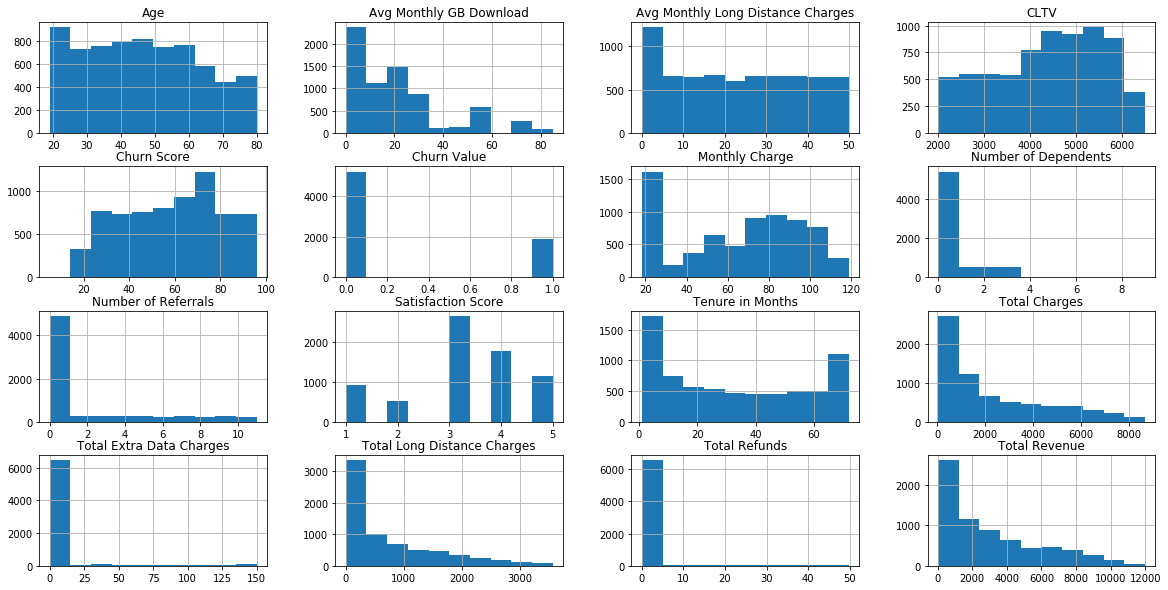

In [16]:
df.hist(figsize=(20,10))
plt.show()

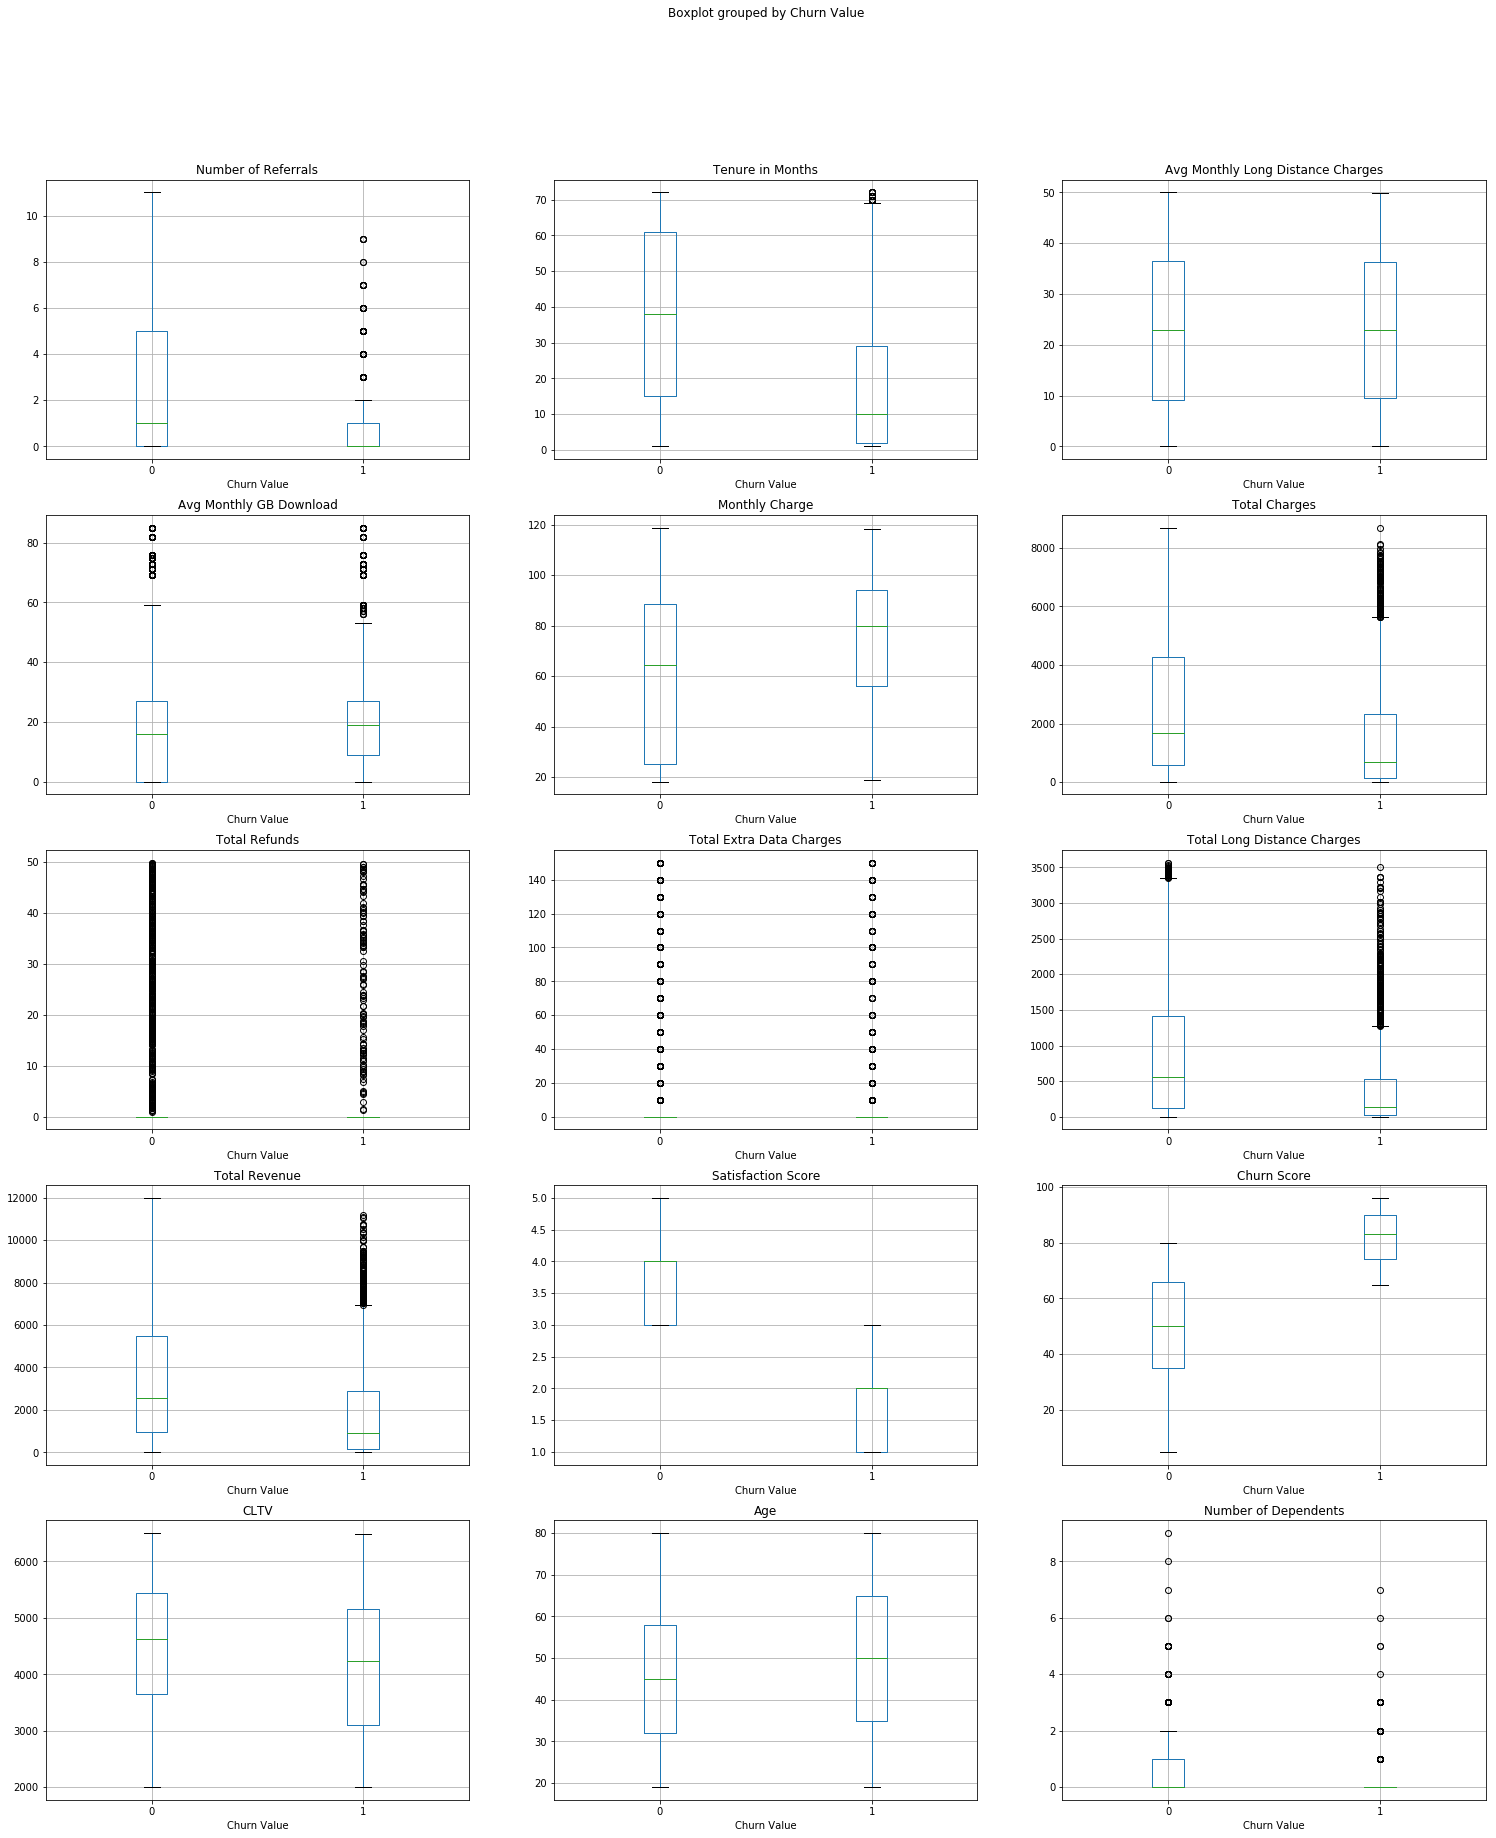

In [17]:
fig, axes = plt.subplots(5,3, figsize=(25,30)) # create figure and axes
names = list(df.select_dtypes(include=[np.number]))
names.remove('Churn Value')

for i,el in enumerate(names):
    a = df.boxplot(el, by="Churn Value", ax=axes.flatten()[i])

#fig.delaxes(axes[5,0]) # remove empty subplot
plt.show()

# Data transformation

## OneHotEncoder - data transformation

Using OneHotEncoder, create binary variable for each categorical varialbe. This will treat categorical variable as nominal instead of being ordinal.

In [18]:
# Dummy variable with one hot-coded
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
df_model = ohe.fit_transform(df)

## features and label
Churn value is the label and anything else (except for features that have names starting with Churn as they are redundant reflections of label) becomes features.

In [19]:
# features
x = df_model.drop('Churn Value', axis = 1)

# Find columns with 'Churn' and drop the features
to_drop_x = list(x.columns[x.columns.str.contains('Churn')])

# features without 'Churn'
x = x.drop(to_drop_x, axis=1)

# label
y = df_model['Churn Value']

# EDA

## Correlation Matrix
Let's find correlation matrix of label vs features. In the next section, we will examine the distribution of the features with abs(correlation) > 0.2 in addtion to label and gender. Note that Satisfaction Score has the strongest relationship with Churn followed by Contract Month-to-Month and Tenure in Months.

In [20]:
# Create correlation matrix
corr_matrix = df_model.corr().abs()
corr_churn = corr_matrix['Churn Value'].sort_values(ascending = False)
corr_churn = corr_churn[~corr_churn.index.str.contains('Churn')]
corr_high = corr_churn[corr_churn > 0.2]
print(corr_high)

Satisfaction Score             0.754649
Contract_Month-to-Month        0.448427
Tenure in Months               0.352861
Contract_Two Year              0.328195
Number of Referrals            0.286540
Internet Type_Fiber Optic      0.279623
Dependents_Yes                 0.248542
Dependents_No                  0.248542
Internet Type_None             0.227890
Internet Service_No            0.227890
Internet Service_Yes           0.227890
Total Long Distance Charges    0.223756
Total Revenue                  0.223003
Number of Dependents           0.218780
Payment Method_Credit Card     0.218528
Offer_Offer E                  0.214648
Name: Churn Value, dtype: float64


In [21]:
# Create correlation matrix
corr_matrix = df_model.corr()
corr_churn = corr_matrix['Churn Value'].sort_values(ascending = True)
corr_churn = corr_churn[~corr_churn.index.str.contains('Churn')]
#corr_high = corr_churn[corr_churn < -0.2]
print(corr_churn)

Satisfaction Score                  -0.754649
Tenure in Months                    -0.352861
Contract_Two Year                   -0.328195
Number of Referrals                 -0.286540
Dependents_Yes                      -0.248542
Internet Type_None                  -0.227890
Internet Service_No                 -0.227890
Total Long Distance Charges         -0.223756
Total Revenue                       -0.223003
Number of Dependents                -0.218780
Payment Method_Credit Card          -0.218528
Total Charges                       -0.198546
Paperless Billing_No                -0.191825
Contract_One Year                   -0.190418
Online Security_Yes                 -0.171226
Unlimited Data_No                   -0.166545
Premium Tech Support_Yes            -0.164674
Senior Citizen_No                   -0.150889
Married_Yes                         -0.150448
Referred a Friend_Yes               -0.149122
CLTV                                -0.127463
Offer_Offer A                     

## Count plot - frequency distribution of each feature

We have imbalanced Churn Values (73.5% - 0, 26.5% - 1) and it is a problem. Asumming all members to be not-churned out, any model already gives us 73.5% prediction accuracy. Thus, our goal is to create models that have higher than 73.5% acccuracy.

In [22]:
def count_plot(feature, df):
    ax = sns.countplot(x=feature, data=df)
    ax.set_title(feature + ' (%)')

    for p in ax.patches:
        ax.annotate( str(round( p.get_height() / len(df_model[feature]) * 100 , 1 )) , (p.get_x() * 1.005, p.get_height() * 1.005), annotation_clip = True)

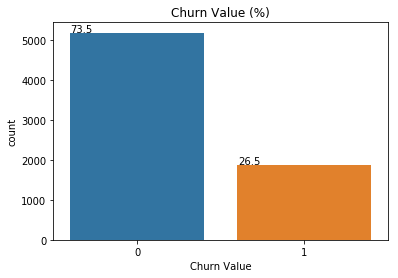

In [23]:
count_plot('Churn Value', df_model)

Let's examine the distribution of Gender. About 50.5% of the samples are male and 49.5% female.

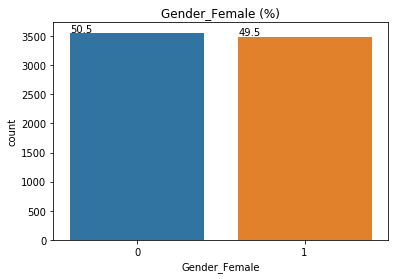

In [24]:
count_plot('Gender_Female', df_model)

Most of customers had score >= 3 and only 20.5% had score < 3.

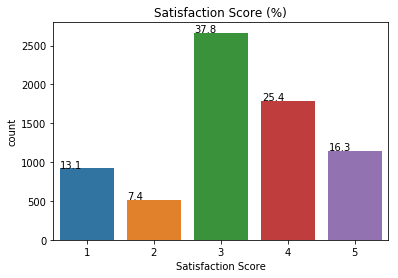

In [25]:
count_plot('Satisfaction Score', df_model)

We know that those who made monthly contract has slightly higher chance to churn out.

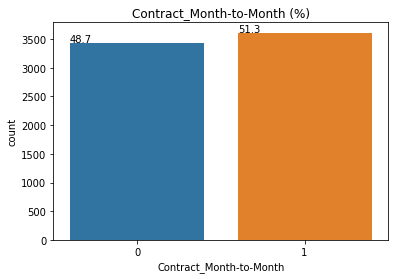

In [26]:
count_plot('Contract_Month-to-Month', df_model)

## Factor plot - Churn value vs feature

Let's examine the distribution of churn Value by gender. Out of samples that are not churned, 50.7% are from female vsand 49.3% are from male. For being churned, 49.8% from female vs 50.2% from male. We confirmed that both female and male are almost equally churned or not churned.

In [62]:
def pv_plot(df, feature, group):
    pv = pd.pivot_table(df_model, index = feature, columns = group, values = 'Age', aggfunc = 'count')
    ax = pv.plot(kind = 'bar', subplots = False, figsize=(20,10))
    ax.set_title(group + ' - ' + feature + ' Count' + ' (%)')

    for i, p in enumerate(ax.patches):
        if i%2 == 0:
            ax.annotate( str( round(p.get_height() / len(df_model[df_model[feature] == 0]) * 100 , 1 ) ), (p.get_x() * 1.005, p.get_height() * 1.005), annotation_clip = True)
        else:
            ax.annotate( str( round(p.get_height() / len(df_model[df_model[feature] == 1]) * 100 , 1 ) ), (p.get_x() * 1.005, p.get_height() * 1.005), annotation_clip = True)

By Gender, both male and female had roughly equal proportion of churn.

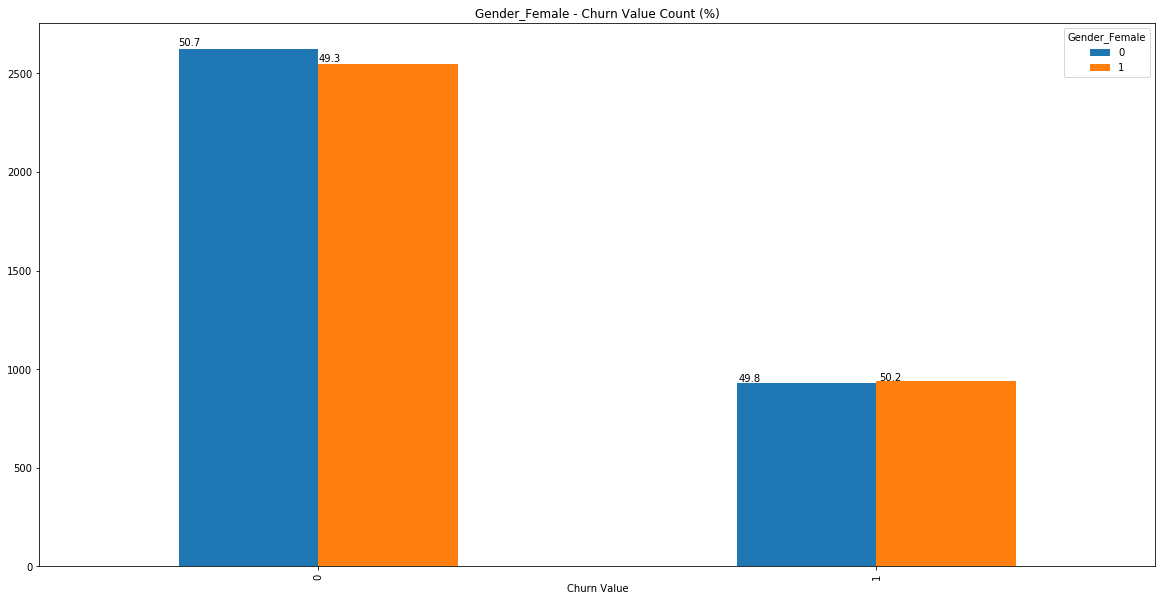

In [63]:
pv_plot(df_model, 'Churn Value', 'Gender_Female')

We know that for none of those who had Satisfaction Score > 3 churned out where as all of those who had Satisfaction Score < 3 all churned out.
This shows that Satisfaction Score has strong relationship with being Churned out or not.

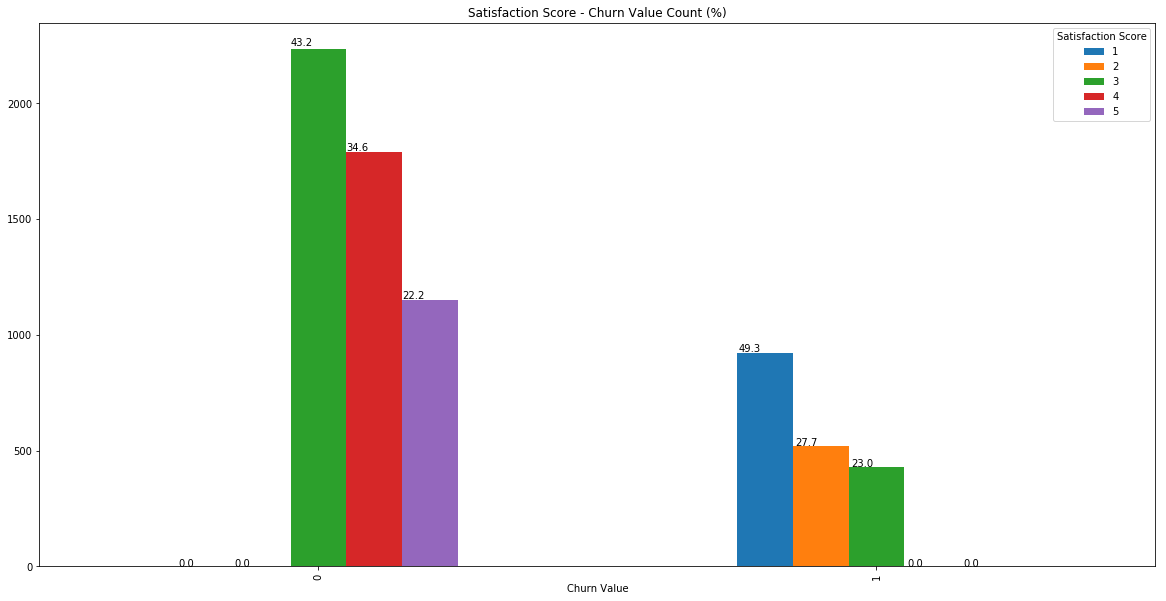

In [64]:
pv_plot(df_model, 'Churn Value', 'Satisfaction Score')  

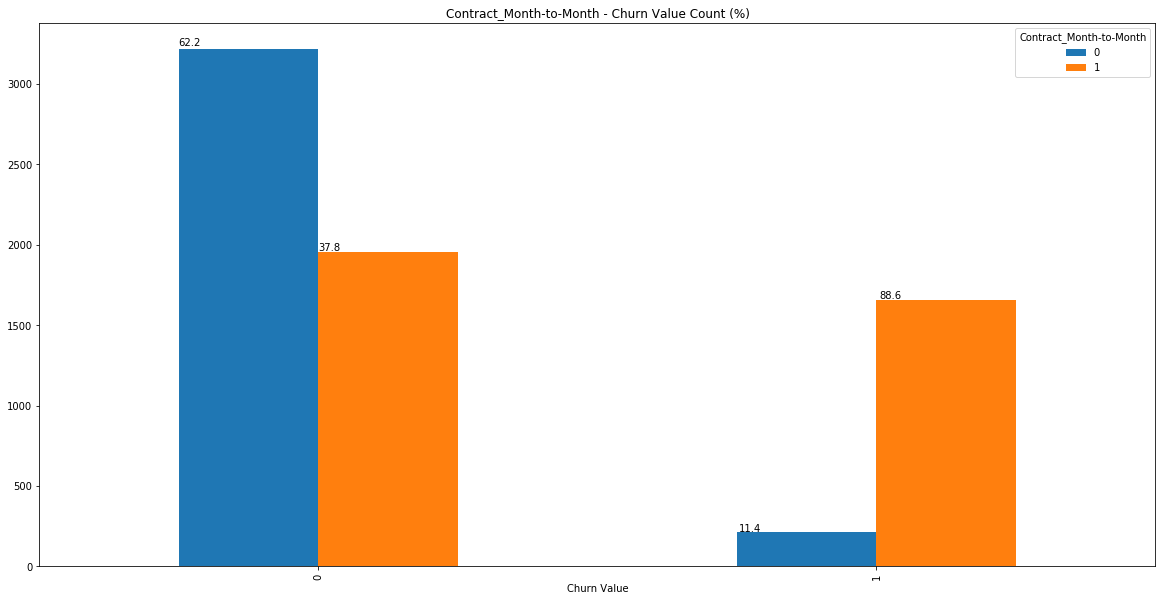

In [65]:
pv_plot(df_model, 'Churn Value', 'Contract_Month-to-Month')

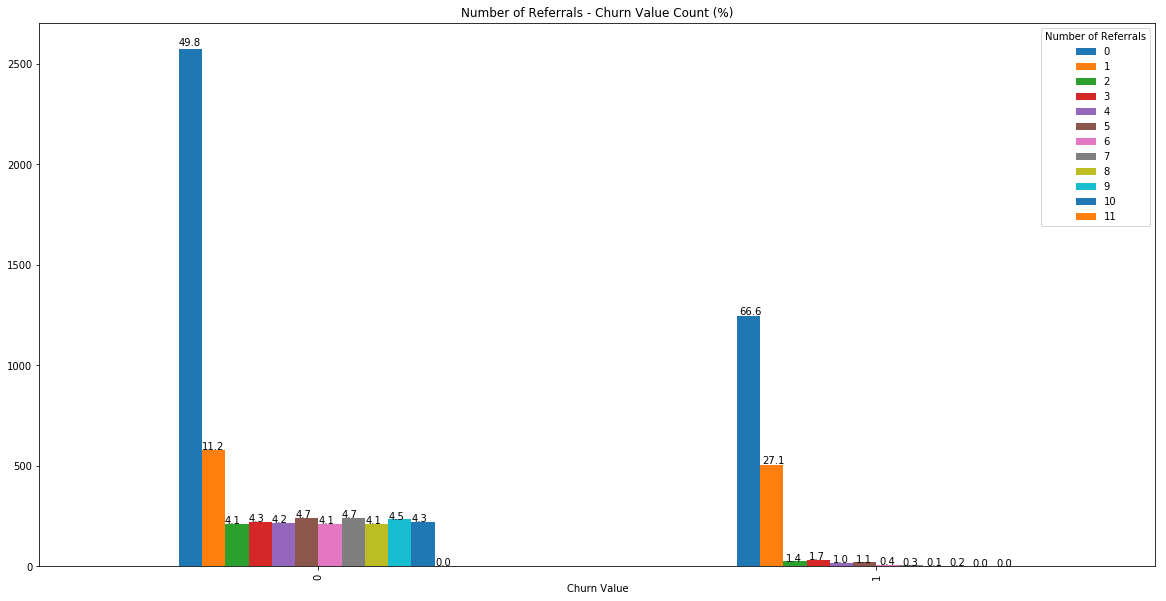

In [66]:
pv_plot(df_model, 'Churn Value', 'Number of Referrals')

## Feature selection
We will drop Churn related variables in x (features) since these variables represent the consequences of being churned out and more or less redundant values. It does not make sense for data scientists to know these information already before predicting the outcome of being churned out or not. In fact, Churn_reason_Nan, for example, infers data scientists that label is not churned even before predicting the outcome.

Removing variables with corr > 0.95 removes one of the one hot encoded values with 2 values as one of them is perfectly correlated to the other. Dropping one of the values for variables such as Gender_Feamle keep the interepretation of model consistent, when it comes to feature importance later on. Intuitively, having both Gender_Female and Gender_Male can confuse data scientists when it comes to interpreting the importance of variable as one of them carry the same information as the other. We will, however, still keep one hot encoded variables with multi values (> 2) in sparse matrix as models deployed in this paper.

In [227]:
# Create correlation matrix
corr_matrix = x.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [228]:
# Find index of feature columns with correlation greater than 0.95 and drop the features
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
x = df_model.drop(to_drop, axis=1)

# Find columns with 'Churn' and drop the features
to_drop_x = list(x.columns[x.columns.str.contains('Churn')])
x = x.drop(to_drop_x, axis=1)

# Modeling

1. We will first create a Random Forest model without handling the imbalance. This is due to the fact that tree-based models generally perform well on imbalanced data as hierchical tree splitting structure allows them to learn signals from both classes. 

2. We will then create a Random Forest model after handling the imbalance (class_weight = 'balanced').

3. A study suggests that pre-processing is recommended even for Random Forest, in case of imbalanced data, as it may improve predictive power further. We will thus implement second model by Random Forest with SMOTE (Synthetic Minority Oversampling Technique) as well to examine pre-processing effect in Random Forest model.(https://www.researchgate.net/publication/329507455_Studying_Weariness_Prediction_Using_SMOTE_and_Random_Forests_Third_International_Conference_SmartCom_2018_Tokyo_Japan_December_10-12_2018_Proceedings) 

4. XGboost, a boosting algorithm, which adjusts weights to handle imbalance will be implemented as well. Parameter tuning is required to set correct scale_pos_weight

5. XGboost with SMOTE will be implemented. Parameter tuning is required to set correct scale_pos_weight.

5. Lastly, Artificial Neural Network with layer > 3 will be implemented in this paper as it is an effective tool in handling imbalanced class. 

For performance evaluation metrics, combination of AUC, Recall and F1 will be used to select the best model. Accuracy will be calculated just as a reference but will not be used for evaluation.

# train-test split
80/20 (train/test) will be implemented for modeling.

In [229]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 46 columns):
Referred a Friend_No                 7043 non-null int64
Number of Referrals                  7043 non-null int64
Tenure in Months                     7043 non-null int64
Offer_None                           7043 non-null int64
Offer_Offer E                        7043 non-null int64
Offer_Offer D                        7043 non-null int64
Offer_Offer C                        7043 non-null int64
Offer_Offer B                        7043 non-null int64
Offer_Offer A                        7043 non-null int64
Phone Service_No                     7043 non-null int64
Avg Monthly Long Distance Charges    7043 non-null float64
Multiple Lines_No                    7043 non-null int64
Internet Service_Yes                 7043 non-null int64
Internet Type_DSL                    7043 non-null int64
Internet Type_Fiber Optic            7043 non-null int64
Internet Type_Cable                 

In [230]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
trainX, testX, trainY, testY = train_test_split(x,y,test_size=0.20, random_state=2019)

# Data preparation for modeling

In [231]:
# SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_sample(trainX, trainY)

X_res = pd.DataFrame(data = X_res, columns=trainX.columns)
#y_res = pd.DataFrame(data = os_smote_Y,columns=trainY.columns)

# Function for prediction

In [232]:
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf) :
    algorithm.fit(training_x, training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y, predictions, target_names= ['Stayed','Churned']))
    print ("Accuracy Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    
    #py.init_notebook_mode(connected=False)
    py.iplot(fig)
    

## Model 1: Random Forest (baseline)

In [233]:
# RFs
rf1 = RandomForestClassifier(n_estimators=2500, max_depth=4, random_state=42)
rf2 = RandomForestClassifier(n_estimators=2500, class_weight = 'balanced', max_depth=4, random_state=42)

telecom_churn_prediction(rf1,trainX,testX,trainY,testY,
                         trainX.columns,"features")

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

      Stayed       0.92      1.00      0.96      1040
     Churned       1.00      0.76      0.86       369

    accuracy                           0.94      1409
   macro avg       0.96      0.88      0.91      1409
weighted avg       0.94      0.94      0.93      1409

Accuracy Score :  0.936124911284599
Area under curve :  0.8780487804878049 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3

## Model 2: Random Forest (class_weight = 'Balanced')

In [234]:
telecom_churn_prediction(rf2,trainX,testX,trainY,testY,
                         trainX.columns,"features")

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

      Stayed       0.98      0.91      0.94      1040
     Churned       0.78      0.93      0.85       369

    accuracy                           0.91      1409
   macro avg       0.88      0.92      0.90      1409
weighted avg       0.92      0.91      0.92      1409

Accuracy Score :  0.9141234918381831
Area under curve :  0.9208450594121326 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (

## Model 3: Random Forest (SMOTE)

In [235]:
telecom_churn_prediction(rf1,X_res,testX,y_res,testY,
                         trainX.columns,"features")

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

      Stayed       0.96      0.96      0.96      1040
     Churned       0.88      0.88      0.88       369

    accuracy                           0.94      1409
   macro avg       0.92      0.92      0.92      1409
weighted avg       0.94      0.94      0.94      1409

Accuracy Score :  0.9368346344925479
Area under curve :  0.9169962997706901 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x

## Model 4: XGBoost (balanced)

In [236]:
from xgboost import XGBClassifier

churn_ratio=trainY.value_counts()[0]/trainY.value_counts()[1]
xgb1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, n_estimators=100,
                    n_jobs=1, objective='binary:logistic', random_state=42,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=churn_ratio, seed=None,
                    silent=True, subsample=1)



churn_ratio2=pd.Series(y_res).value_counts()[0]/pd.Series(y_res).value_counts()[1]
xgb2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, n_estimators=100,
                    n_jobs=1, objective='binary:logistic', random_state=42,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=churn_ratio2, seed=None,
                    silent=True, subsample=1)

In [237]:
telecom_churn_prediction(xgb1,trainX,testX,trainY,testY,
                         trainX.columns,"features")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.756, seed=None,
              silent=True, subsample=1, verbosity=1)

 Classification report : 
               precision    recall  f1-score   support

      Stayed       0.97      0.98      0.97      1040
     Churned       0.94      0.92      0.93       369

    accuracy                           0.96      1409
   macro avg       0.95      0.95      0.95      1409
weighted avg       0.96      0.96      0.96      1409

Accuracy Score :  0.9616749467707594
Area under curve :  0.9469368876381071 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3        

## Model 5: XGBoost (SMOTE)

In [238]:
telecom_churn_prediction(xgb2,X_res,testX,y_res,testY,
                         trainX.columns,"features")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, seed=None,
              silent=True, subsample=1, verbosity=1)

 Classification report : 
               precision    recall  f1-score   support

      Stayed       0.97      0.99      0.98      1040
     Churned       0.96      0.91      0.93       369

    accuracy                           0.97      1409
   macro avg       0.96      0.95      0.95      1409
weighted avg       0.97      0.97      0.96      1409

Accuracy Score :  0.9652235628105039
Area under curve :  0.9467180008338546 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3          

## Model 6: ANN - Centered/Scaled

In [239]:
#from sklearn.utils.class_weight import compute_class_weight
#weights = compute_class_weight('balanced', np.unique(trainY), trainY)
#weights

In [306]:
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

classifier = Sequential()

# input layer
classifier.add(Dense(units=6,kernel_initializer="uniform",activation="relu",input_shape=(46,)))
classifier.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center = True, scale = True)) # center, scale is effective for our case

# hidden layer 1
classifier.add(Dense(units=6,kernel_initializer="uniform",activation="relu"))
classifier.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center = True, scale = True))

# hidden layer 2
classifier.add(Dense(units=6,kernel_initializer="uniform",activation="relu"))
classifier.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center = True, scale = True))

# output layer
classifier.add(Dropout(0.2))
classifier.add(Dense(units=1,kernel_initializer="uniform",activation="sigmoid")) #softmax isn't effective for our case

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# fit the model
classifier.fit(trainX, trainY,  batch_size = 100, nb_epoch = 100)

Epoch 1/100
5634/5634 [==============================] - 2s 314us/step - loss: 0.6656 - accuracy: 0.5941
Epoch 2/100
5634/5634 [==============================] - 0s 57us/step - loss: 0.6003 - accuracy: 0.6984
Epoch 3/100
5634/5634 [==============================] - 0s 54us/step - loss: 0.5254 - accuracy: 0.7696
Epoch 4/100
5634/5634 [==============================] - 0s 55us/step - loss: 0.4706 - accuracy: 0.7953
Epoch 5/100
5634/5634 [==============================] - 0s 52us/step - loss: 0.3790 - accuracy: 0.8500
Epoch 6/100
5634/5634 [==============================] - 0s 55us/step - loss: 0.2891 - accuracy: 0.8983
Epoch 7/100
5634/5634 [==============================] - 0s 52us/step - loss: 0.2481 - accuracy: 0.9073
Epoch 8/100
5634/5634 [==============================] - 0s 54us/step - loss: 0.2196 - accuracy: 0.9207
Epoch 9/100
5634/5634 [==============================] - 0s 53us/step - loss: 0.1871 - accuracy: 0.9297
Epoch 10/100
5634/5634 [==============================] - 0s 55

5634/5634 [==============================] - 0s 53us/step - loss: 0.1219 - accuracy: 0.9494
Epoch 80/100
5634/5634 [==============================] - 0s 50us/step - loss: 0.1348 - accuracy: 0.9444
Epoch 81/100
5634/5634 [==============================] - 0s 48us/step - loss: 0.1256 - accuracy: 0.9478
Epoch 82/100
5634/5634 [==============================] - 0s 50us/step - loss: 0.1197 - accuracy: 0.9487
Epoch 83/100
5634/5634 [==============================] - 0s 50us/step - loss: 0.1138 - accuracy: 0.9526
Epoch 84/100
5634/5634 [==============================] - 0s 56us/step - loss: 0.1221 - accuracy: 0.9526
Epoch 85/100
5634/5634 [==============================] - 0s 49us/step - loss: 0.1318 - accuracy: 0.9455
Epoch 86/100
5634/5634 [==============================] - 0s 52us/step - loss: 0.1268 - accuracy: 0.9478
Epoch 87/100
5634/5634 [==============================] - 0s 52us/step - loss: 0.1150 - accuracy: 0.9519
Epoch 88/100
5634/5634 [==============================] - 0s 51us/st

In [339]:
predictions = classifier.predict(testX)
predictions = (predictions > 0.5)


print ("\n Classification report : \n",classification_report(testY, predictions, target_names= ['Stayed','Churned']))
print ("Accuracy Score : ",accuracy_score(testY,predictions))
#confusion matrix
#conf_matrix = confusion_matrix(testY,predictions)
#conf_matrix
#roc_auc_score
model_roc_auc = roc_auc_score(testY,predictions) 
print ("Area under curve : ",model_roc_auc,"\n")


 Classification report : 
               precision    recall  f1-score   support

      Stayed       0.96      0.98      0.97      1040
     Churned       0.95      0.89      0.92       369

    accuracy                           0.96      1409
   macro avg       0.95      0.93      0.94      1409
weighted avg       0.96      0.96      0.96      1409

Accuracy Score :  0.957416607523066
Area under curve :  0.9344355847404627 



## Model 7: ANN (SMOTE)

In [242]:
classifier2 = Sequential()

# input layer
classifier2.add(Dense(units=6,kernel_initializer="uniform",activation="relu",input_shape=(46,)))
classifier2.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

# hidden layer 1
classifier2.add(Dense(units=6,kernel_initializer="uniform",activation="relu"))
classifier2.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

# hidden layer 2
classifier2.add(Dense(units=6,kernel_initializer="uniform",activation="relu"))
classifier2.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

# output layer
classifier2.add(Dropout(0.2))
classifier2.add(Dense(units=1,kernel_initializer="uniform",activation="sigmoid")) #softmax isn't effective for our case

classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# fit the model
classifier2.fit(X_res, y_res, batch_size = 100, nb_epoch = 100)

Epoch 1/100
8268/8268 [==============================] - 2s 221us/step - loss: 0.6580 - accuracy: 0.6393
Epoch 2/100
8268/8268 [==============================] - 0s 50us/step - loss: 0.5610 - accuracy: 0.7291
Epoch 3/100
8268/8268 [==============================] - 0s 49us/step - loss: 0.4801 - accuracy: 0.7760
Epoch 4/100
8268/8268 [==============================] - 0s 51us/step - loss: 0.4033 - accuracy: 0.8247
Epoch 5/100
8268/8268 [==============================] - 0s 57us/step - loss: 0.2913 - accuracy: 0.8874
Epoch 6/100
8268/8268 [==============================] - 0s 52us/step - loss: 0.2470 - accuracy: 0.9031
Epoch 7/100
8268/8268 [==============================] - 0s 49us/step - loss: 0.1887 - accuracy: 0.9313
Epoch 8/100
8268/8268 [==============================] - 0s 57us/step - loss: 0.1712 - accuracy: 0.9336
Epoch 9/100
8268/8268 [==============================] - 0s 54us/step - loss: 0.1662 - accuracy: 0.9375
Epoch 10/100
8268/8268 [==============================] - 0s 54

In [243]:
predictions = classifier2.predict(testX)
predictions = (predictions > 0.5)


print ("\n Classification report : \n",classification_report(testY, predictions, target_names= ['Stayed','Churned']))
print ("Accuracy Score : ",accuracy_score(testY,predictions))
#confusion matrix
#conf_matrix = confusion_matrix(testY,predictions)
#conf_matrix
#roc_auc_score
model_roc_auc = roc_auc_score(testY,predictions) 
print ("Area under curve : ",model_roc_auc,"\n")


 Classification report : 
               precision    recall  f1-score   support

      Stayed       0.97      0.96      0.96      1040
     Churned       0.88      0.93      0.90       369

    accuracy                           0.95      1409
   macro avg       0.93      0.94      0.93      1409
weighted avg       0.95      0.95      0.95      1409

Accuracy Score :  0.9481902058197303
Area under curve :  0.9412992495309569 



## pr-auc cross validtion - ANN (centered/scaled)

Epoch 1/3
4695/4695 [==============================] - 0s 54us/step - loss: 0.0959 - accuracy: 0.9585
Epoch 2/3
4695/4695 [==============================] - 0s 52us/step - loss: 0.1012 - accuracy: 0.9587
Epoch 3/3
4695/4695 [==============================] - 0s 56us/step - loss: 0.0996 - accuracy: 0.9595
Epoch 1/3
4695/4695 [==============================] - 0s 55us/step - loss: 0.1014 - accuracy: 0.9606
Epoch 2/3
4695/4695 [==============================] - 0s 54us/step - loss: 0.0975 - accuracy: 0.9634
Epoch 3/3
4695/4695 [==============================] - 0s 54us/step - loss: 0.1020 - accuracy: 0.9570
Epoch 1/3
4696/4696 [==============================] - 0s 52us/step - loss: 0.0991 - accuracy: 0.9600
Epoch 2/3
4696/4696 [==============================] - 0s 54us/step - loss: 0.0966 - accuracy: 0.9617
Epoch 3/3
4696/4696 [==============================] - 0s 56us/step - loss: 0.1006 - accuracy: 0.9568


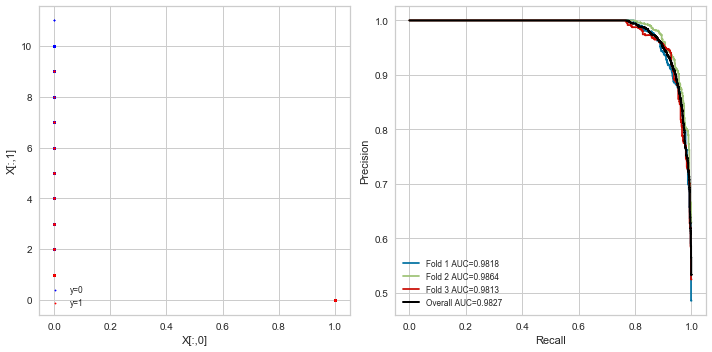

In [338]:
import matplotlib.pyplot as plt
import numpy
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC

FOLDS = 3

#X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=10.0,
#    random_state=12345)

X = np.array(x)
y = np.array(y)

f, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(X[y==0,0], X[y==0,1], color='blue', s=2, label='y=0')
axes[0].scatter(X[y!=0,0], X[y!=0,1], color='red', s=2, label='y=1')
axes[0].set_xlabel('X[:,0]')
axes[0].set_ylabel('X[:,1]')
axes[0].legend(loc='lower left', fontsize='small')


k_fold = KFold(n_splits=FOLDS, shuffle=True, random_state=12345)
#predictor = SVC(kernel='linear', C=1.0, probability=True, random_state=12345)
predictor = classifier #xgb1



y_real = []
y_proba = []
for i, (train_index, test_index) in enumerate(k_fold.split(X)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain, batch_size = 100, nb_epoch = 3)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba) #[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[1].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba) #[:,1])

y_real = numpy.concatenate(y_real)
y_proba = numpy.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))
axes[1].step(recall, precision, label=lab, lw=2, color='black')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left', fontsize='small')

f.tight_layout()
f.savefig('result.png')


## Permutation importance

In [153]:
#XGB (SMOTE) - permutation importance (test)
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb2, scoring="f1", random_state=42).fit(testX, testY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
0.5256 ± 0.0375,Satisfaction Score
0.0252 ± 0.0055,Number of Referrals
0.0242 ± 0.0153,Online Security_No
0.0206 ± 0.0091,Contract_Month-to-Month
0.0198 ± 0.0058,Total Charges
0.0146 ± 0.0052,Referred a Friend_No
0.0139 ± 0.0070,Tenure in Months
0.0135 ± 0.0060,Dependents_No
0.0132 ± 0.0079,CLTV
0.0123 ± 0.0093,Monthly Charge


In [154]:
perm = PermutationImportance(xgb2,  scoring="f1", random_state=42).fit(X_res, y_res)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
0.3649 ± 0.0085,Satisfaction Score
0.0113 ± 0.0010,Online Security_No
0.0086 ± 0.0010,Number of Referrals
0.0053 ± 0.0009,CLTV
0.0051 ± 0.0014,Contract_Month-to-Month
0.0044 ± 0.0005,Dependents_No
0.0041 ± 0.0008,Monthly Charge
0.0038 ± 0.0006,Total Charges
0.0035 ± 0.0005,Referred a Friend_No
0.0025 ± 0.0005,Avg Monthly Long Distance Charges


## Precision-Recall curve

Random Forest (baseline): auc=0.958


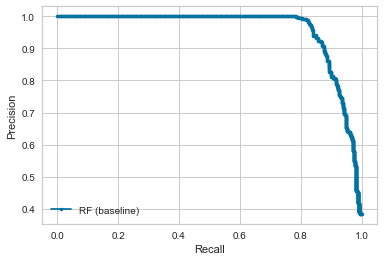

In [295]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import average_precision_score

trainy = trainY
testy = testY

# fit a model
model = rf1
model.fit(trainX, trainy)
# predict probabilities
#: f1=0.861 auc=0.958


lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat),  average_precision_score(testy, lr_probs) #,  auc(lr_recall, lr_precision)
# summarize scores
#print('Random Forest (baseline): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('Random Forest (baseline): auc=%.3f' % (lr_auc))

# plot the precision-recall curves
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='RF (baseline)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Random Forest (balanced): auc=0.963


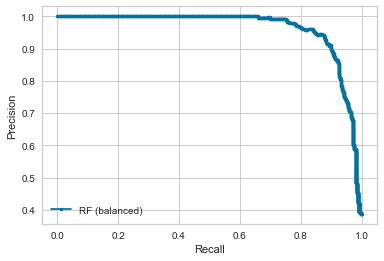

In [294]:
trainy = trainY
testy = testY

# fit a model
model = rf2
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), average_precision_score(testy, lr_probs) # auc(lr_recall, lr_precision)


# summarize scores
#print('Random Forest (balanced): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('Random Forest (balanced): auc=%.3f' % (lr_auc))

# plot the precision-recall curves
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='RF (balanced)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Random Forest (SMOTE): auc=0.957


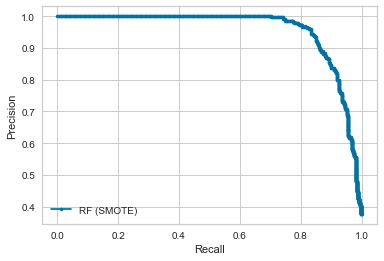

In [296]:
trainy = y_res
testy = testY

# fit a model
model = rf1
model.fit(X_res, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), average_precision_score(testy, lr_probs) #auc(lr_recall, lr_precision)
# summarize scores
#print('Random Forest (SMOTE): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('Random Forest (SMOTE): auc=%.3f' % (lr_auc))

# plot the precision-recall curves
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='RF (SMOTE)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

XGboost (balanced): auc=0.978


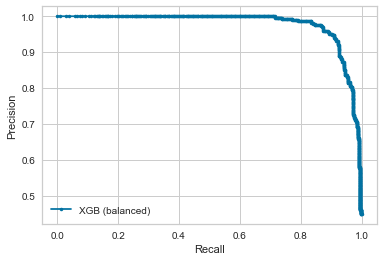

In [297]:
trainy = trainY
testy = testY

# fit a model
model = xgb1
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), average_precision_score(testy, lr_probs)# auc(lr_recall, lr_precision)
# summarize scores
#print('XGboost (balanced): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('XGboost (balanced): auc=%.3f' % (lr_auc))

# plot the precision-recall curves
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='XGB (balanced)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

XGboost (SMOTE): pr-auc=0.978


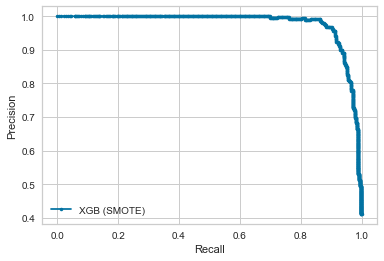

In [298]:
trainy = y_res
testy = testY

# fit a model
model = xgb2
model.fit(X_res, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), average_precision_score(testy, lr_probs)# auc(lr_recall, lr_precision)
# summarize scores
#print('XGboost (SMOTE): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('XGboost (SMOTE): pr-auc=%.3f' % (lr_auc))

# plot the precision-recall curves
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='XGB (SMOTE)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ANN (centered/scaled): pr-auc=0.968


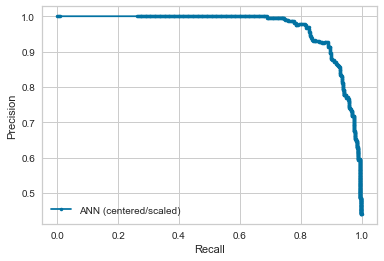

In [328]:
trainy = trainY
testy = testY

# fit a model
model = classifier
#model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
yhat = (yhat > 0.5)

lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), average_precision_score(testy, lr_probs)# auc(lr_recall, lr_precision)
# summarize scores
#print('ANN (centered/scaled): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('ANN (centered/scaled): pr-auc=%.3f' % (lr_auc))

# plot the precision-recall curves
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='ANN (centered/scaled)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ANN (SMOTE): pr-auc=0.974


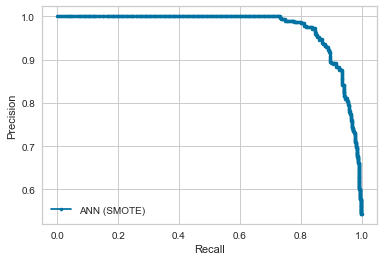

In [300]:
trainy = y_res
testy = testY

# fit a model
model = classifier2
#model.fit(X_res, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
yhat = (yhat > 0.5)

lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), average_precision_score(testy, lr_probs)# auc(lr_recall, lr_precision)
# summarize scores
#print('ANN (SMOTE): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('ANN (SMOTE): pr-auc=%.3f' % (lr_auc))

# plot the precision-recall curves
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='ANN (SMOTE)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Conclusion

Through careful imputation for missing data, dummy variable creation and removing variable, we achieved > 90% PR-AUC/ROC-AUC in all of models. 